In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.data import AUTOTUNE
import tensorflow_addons as tfa

import random
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
os.environ['KAGGLE_USERNAME'] = ''  # Your Kaggle username
os.environ['KAGGLE_KEY'] = ''  # Your Kaggle API key
os.environ['URN'] = '6644818'  # Your URN: submissions without a URN will not count#

# !kaggle competitions download -c uos-com2028-21-22-cw()
# !unzip uos-com2028-21-22-cw.zip

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-05-11 09:15:31.075804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 09:15:31.129502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 09:15:31.129648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Read the data

In [4]:
color_mode = 'grayscale'
image_size = (32, 32)
image_shape = (*image_size, 1)
batch_size = 800

num_classes = 8

In [5]:
# read all labels
train_labels_dp = pd.read_csv('train.csv')
train_labels = tf.constant(train_labels_dp.loc[:, 'Cell type'].values)

2022-05-11 09:15:31.243753: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 09:15:31.244654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 09:15:31.244899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 09:15:31.245075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
# based on https://www.tensorflow.org/tutorials/load_data/images

def pathToLabel(path):
  path = tf.strings.regex_replace(path, "./train/", "")
  path = tf.strings.regex_replace(path, ".jpg", "")
  return train_labels[tf.strings.to_number(path, out_type=tf.int32)]

def decode_image(img):
  # channels were reduced to 1 since image is grayscale
  img = tf.io.decode_jpeg(img, channels=1)

  return tf.image.resize(img, image_size)

def process_path(path, addPath=False):
  label = pathToLabel(path)

  img = tf.io.read_file(path)
  img = decode_image(img)
  img = tf.image.adjust_gamma(img, 1.1)
  if addPath:
    return img, label, path
  else:
    return img, label

def process_path_test(path, addPath=False):
  img = tf.io.read_file(path)
  img = decode_image(img)
  img = tf.image.adjust_gamma(img, 1.1)
  if addPath:
    return img, path
  else:
    return img

def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size= 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(AUTOTUNE)
  return ds

def prepare_dataset(ds: tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
  ds = configure_for_performance(ds)
  return ds

def prepare_dataset_test(ds: tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.map(process_path_test, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(1)
  ds = ds.prefetch(AUTOTUNE)
  return ds

In [7]:
seed = random.randint(0, 10000)

print("seed: %d" % seed)

# Read all the files from the direcotry
list_ds = tf.data.Dataset.list_files(str('./train/*'), shuffle=False)

image_count = len(list_ds)

list_ds = list_ds.shuffle(image_count, seed=seed)

val_size = int(image_count * 0.333)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

seed: 8825


In [8]:
# Show some images
# image_batch, label_batch  = next(iter(train_ds))

# plt.figure(figsize=image_size)
# for i in range(4):
#   ax = plt.subplot(2, 2, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')

#   label = label_batch[i]
#   path = ""#str(path_batch[i].numpy())

#   plt.title(str(label.numpy()) + " " + path)
#   plt.axis("off")


Read the testing set

Create a model

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=image_shape),
    layers.RandomRotation(0.4),
    layers.RandomContrast(0.1),
  ]
)

track = 0


def addBlock(
    b_size: int,
    filter_size: int,
    kernel_size: int = 3,
    top: bool = True,
    pooling_same: bool = False,
    pool_func=layers.MaxPool2D
):
    global track
    model = keras.Sequential(name=f"{track}-{b_size}-{filter_size}-{kernel_size}")
    track += 1
    for _ in range(b_size):
        model.add(layers.Conv2D(
            filter_size,
            kernel_size,
            padding="same"
        ))
        model.add(layers.ReLU())
    if top:
        if pooling_same:
            model.add(pool_func(padding="same", strides=(1, 1)))
        else:
            model.add(pool_func())
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.4))
    return model


model = keras.Sequential()

model.add(data_augmentation)

model.add(layers.Rescaling(1.0/255, input_shape=image_shape))

model.add(addBlock(1, 64, 1, pooling_same=True, pool_func=layers.AveragePooling2D))

model.add(addBlock(2, 128, 3, pool_func=layers.AveragePooling2D))

model.add(addBlock(2, 250, 3, pool_func=layers.AveragePooling2D))

model.add(addBlock(2, 500, 3, pool_func=layers.AveragePooling2D))

model.add(addBlock(1, 1000, 3, pooling_same=True, pool_func=layers.AveragePooling2D))

model.add(layers.GlobalAvgPool2D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes))
model.add(layers.Softmax())

model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tfa.optimizers.AdamW(weight_decay=1e-4),
  metrics=['accuracy']
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 32, 32, 1)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 0-1-64-1 (Sequential)       (None, 32, 32, 64)        384       
                                                                 
 1-2-128-3 (Sequential)      (None, 16, 16, 128)       221952    
                                                                 
 2-2-250-3 (Sequential)      (None, 8, 8, 250)         852000    
                                                                 
 3-2-500-3 (Sequential)      (None, 4, 4, 500)         3378000   
                                                                 
 4-1-1000-3 (Sequential)     (None, 4, 4, 1000)       

In [17]:
# https://www.tensorflow.org/tutorials/keras/regression
def plot_loss(history, val=True, color="b", save=False):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    if val:
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid(True)
    if save:
        plt.savefig('./fig.png')
    else:
        plt.show()

Epoch 1/120
125/126 [============================>.] - ETA: 0s - loss: 1.2265 - accuracy: 0.5480

2022-05-10 13:38:47.386813: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1080000000 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.24501, saving model to checkpoints/check.ckpt
126/126 [==============================] - 101s 802ms/step - loss: 1.2264 - accuracy: 0.5480 - val_loss: 3.2134 - val_accuracy: 0.2450
Epoch 2/120
125/126 [============================>.] - ETA: 0s - loss: 1.1778 - accuracy: 0.5641

2022-05-10 13:40:27.419029: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1080000000 exceeds 10% of free system memory.



Epoch 2: val_accuracy improved from 0.24501 to 0.37329, saving model to checkpoints/check.ckpt
126/126 [==============================] - 100s 793ms/step - loss: 1.1779 - accuracy: 0.5641 - val_loss: 1.7094 - val_accuracy: 0.3733
Epoch 3/120
125/126 [============================>.] - ETA: 0s - loss: 1.1478 - accuracy: 0.5753

2022-05-10 13:42:09.949600: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1080000000 exceeds 10% of free system memory.



Epoch 3: val_accuracy improved from 0.37329 to 0.45854, saving model to checkpoints/check.ckpt
126/126 [==============================] - 102s 813ms/step - loss: 1.1477 - accuracy: 0.5753 - val_loss: 1.4543 - val_accuracy: 0.4585
Epoch 4/120
125/126 [============================>.] - ETA: 0s - loss: 1.1233 - accuracy: 0.5845

2022-05-10 13:43:53.620369: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1080000000 exceeds 10% of free system memory.



Epoch 4: val_accuracy improved from 0.45854 to 0.56919, saving model to checkpoints/check.ckpt
126/126 [==============================] - 104s 822ms/step - loss: 1.1233 - accuracy: 0.5845 - val_loss: 1.1359 - val_accuracy: 0.5692
Epoch 5/120
125/126 [============================>.] - ETA: 0s - loss: 1.1057 - accuracy: 0.5902
Epoch 5: val_accuracy improved from 0.56919 to 0.59942, saving model to checkpoints/check.ckpt
126/126 [==============================] - 105s 837ms/step - loss: 1.1057 - accuracy: 0.5902 - val_loss: 1.0703 - val_accuracy: 0.5994
Epoch 6/120
125/126 [============================>.] - ETA: 0s - loss: 1.0907 - accuracy: 0.5958
Epoch 6: val_accuracy did not improve from 0.59942
126/126 [==============================] - 106s 841ms/step - loss: 1.0907 - accuracy: 0.5958 - val_loss: 1.0964 - val_accuracy: 0.5953
Epoch 7/120
125/126 [============================>.] - ETA: 0s - loss: 1.0795 - accuracy: 0.6013
Epoch 7: val_accuracy did not improve from 0.59942
126/126 [==

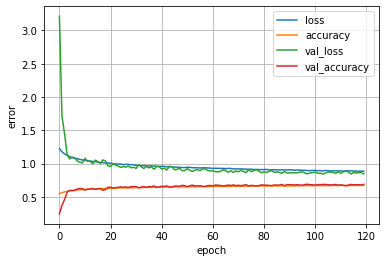

In [19]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

checkpoint_path = 'checkpoints/check.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=True,
    mode="max",
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

his = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=120,
    callbacks=[tensorboard_callback, checkpoint]
)

plot_loss(his, save=True)

!notify-send -i "$(pwd)/fig.png" "AI: finished training"

In [13]:
# model.save('test_now.h5')
# model = keras.models.load_model('test_now.h5')

In [20]:
model.load_weights('checkpoints/check.ckpt')

In [15]:
test_ds = image_dataset_from_directory(
  './test', 
  labels=None, 
  shuffle=False,
  color_mode=color_mode,
  batch_size=1,
  image_size=image_size)


Found 50000 files belonging to 1 classes.


In [26]:
test_list_ds = tf.data.Dataset.list_files(str('./test/*'), shuffle=False)

test_ds = prepare_dataset_test(test_list_ds)

In [27]:
predictions = [np.argmax(x) for x in model.predict(test_ds)]
predictions[:10]

[7, 6, 7, 0, 4, 6, 6, 0, 7, 6]

In [28]:
from pandas import DataFrame
DataFrame(data={'Cell type': predictions}).to_csv('predictions.csv', index_label='Id')

In [29]:
!kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

100%|█████████████████████████████████████████| 380k/380k [00:01<00:00, 255kB/s]
Successfully submitted to COM2028 21/22 CW